# Imports

In [12]:
# IMPORTS
import numpy as np
import pandas as pd
import scipy
import matplotlib
import seaborn as sns
import sklearn
import tensorflow
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import datetime
import os

# Fetch data

In [2]:
# @title Download the data

import os, requests, tarfile

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

In [3]:
with np.load(fname) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

# Visualization and pre-processing

## Initial insight into data


`labels` is a 4 by stim array of class names:  
- row 3 has the labels predicted by a deep neural network (DNN) trained on Imagenet
- rows 0-2 correspond to different levels of the wordnet hierarchy for the DNN predictions

In [4]:
print(labels[:, :4])

[['artifact' 'entity' 'animal' 'animal']
 ['instrumentality' 'round shape' 'vertebrate' 'vertebrate']
 ['equipment' 'sphere' 'mammal' 'amphibian']
 ['croquet ball' 'bubble' 'komondor' 'tailed frog']]


In [8]:
print(dat.keys())

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


`dat` has the following fields:  
- `stimuli`: stim x i x j array of grayscale stimulus images
- `stimuli_test`: stim x i x j array of grayscale stimulus images in the test set  
- `responses`: stim x voxel array of z-scored BOLD response amplitude
- `responses_test`:  stim x voxel array of z-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

In [9]:
print(dat["stimuli"].shape)

(1750, 128, 128)


In [10]:
print(dat["responses"].shape)

(1750, 8428)


This is the number of voxels in each ROI. Note that `"Other"` voxels have been removed from this version of the dataset:

In [11]:
roi_count = dict(zip(dat["roi_names"], np.bincount(dat["roi"])))

print(roi_count)

{'Other': 0, 'V1': 1294, 'V2': 2083, 'V3': 1790, 'V3A': 484, 'V3B': 314, 'V4': 1535, 'LatOcc': 928}


Each stimulus is a 128 x 128 grayscale array:

C:\Users\mikke\AppData\Local\Temp\ipykernel_22348\3010978900.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


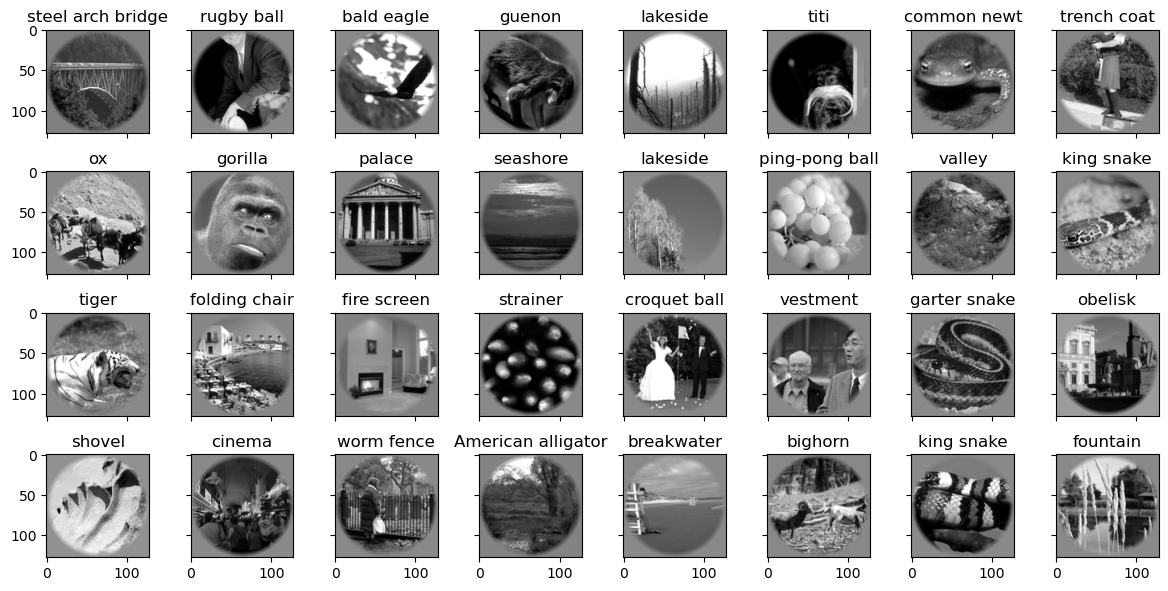

In [33]:
fig, axs = plt.subplots(4, 8, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, dat["stimuli_test"], val_labels[-1, :]):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
fig.tight_layout()
fig.show()

## Visualization

### Training data:

Each stimulus is associated with a pattern of BOLD response across voxels in visual cortex:

C:\Users\mikke\AppData\Local\Temp\ipykernel_26264\2625672689.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


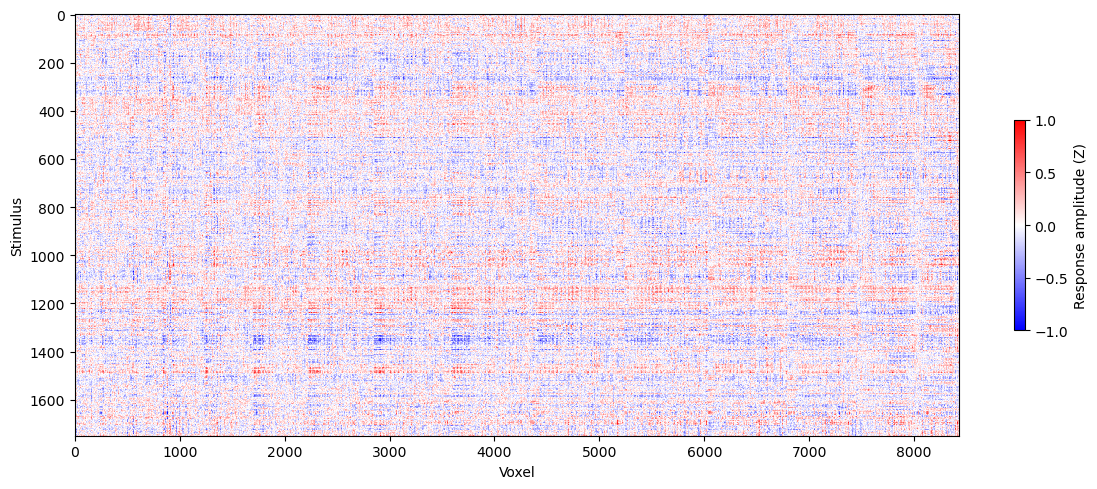

In [63]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(dat["responses"],
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

### Test data:

The training/validation splits from the original paper are retained, so the 120 test stimuli and responses are in separate data structures:

In [ ]:
fig, ax = plt.subplots(figsize=(12, 2.5))
ax.set(xlabel="Voxel", ylabel="Test Stimulus")
heatmap = ax.imshow(dat["responses_test"],
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.75, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

### Other visualisations:

In [ ]:
# Sort dat['roi'] ascending and use this order to sort dat['responses']
roi_order = np.argsort(dat['roi'])
sorted_roi = dat['roi'][roi_order]
sorted_responses = dat['responses'][:, roi_order]

# Plot the sorted responses
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(sorted_responses,
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

In [ ]:
# Split dat['responses'] by their corresponding category in labels

# Get the unique categories in labels
categories = np.unique(labels[0, :])
print("Unique categories:", categories)

# Split the responses by category (each category should have shape (num_img, 8428))
responses_by_category = [dat['responses'][labels[0, :] == category, :] for category in categories]

# Print shapes of responses_by_category
for category, category_responses in zip(categories, responses_by_category):
  print(f"Category {category} has shape {category_responses.shape}")

In [ ]:
# Plot the responses for each category
for i in range(len(categories)):
    fig, ax = plt.subplots(figsize=(12, 2.5))
    ax.set_title(f"Category: {categories[i]}, # of images: {responses_by_category[i].shape[0]}")
    ax.set(xlabel="Voxel", ylabel="Stimulus")
    heatmap = ax.imshow(responses_by_category[i],
                        aspect="auto", vmin=-1, vmax=1, cmap="bwr")
    fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
    fig.tight_layout()
    fig.show()

### Visualization of the means for the ROIs, compared across different stimuli of the same category

In [ ]:
# Functions for plotting barplots of the different ROI's means for a specific category

def compute_roi_bins(image_index):
    responses = dat["responses"]
    rois = dat["roi"]
    roi_names_count = np.bincount(rois)[1:]

    roi_bins = [0, 0, 0, 0, 0, 0, 0]
    # For one image, go through all voxels recorded
    for i in range(len(responses[0])):
        roi_index = rois[i] - 1
        roi_bins[roi_index] += responses[image_index][i]
    for i in range(len(roi_bins)):
        roi_bins[i] /= roi_names_count[i]
    
    return roi_bins

def compute_roi_distributions_from_category(category, category_hierarchy, count):
    index = 0
    graphs_xvalues = []
    graphs_specific_labels = []
    while len(graphs_xvalues) < count:
        #print(labels[category_hierarchy][index], '/', category)
        if labels[category_hierarchy][index] == category: # category hierachy level
            graphs_xvalues.append(compute_roi_bins(index))
            graphs_specific_labels.append(labels[3][index])
        index += 1

    return graphs_xvalues, graphs_specific_labels

def barplot_roi_distribution(category, graph_xvalues, graph_specific_labels, ylim=[-0.4, 0.4], plot_rows=3, plot_cols=4):
    figure, axis = plt.subplots(plot_rows, plot_cols, figsize=(12,8))
    figure.suptitle(category)
    for ax, im, lbl in zip(axis.flat, graph_xvalues, graph_specific_labels):
        ax.set_ylim(ylim)
        ax.bar(range(len(im)), im)
        ax.set_title(lbl)
    figure.tight_layout()
    figure.show()

In [ ]:
# Plot barplots of ROI distribution for a specified category
# Specify category name, it's hierarchy level, and how many stimili there is
category_name = 'tree frog'
category_hierarchy = 3
count = 6
roi_distributions_values, roi_distibutions_labels = compute_roi_distributions_from_category(category_name, category_hierarchy, count)
barplot_roi_distribution(category_name, roi_distributions_values, roi_distibutions_labels)

C:\Users\mikke\AppData\Local\Temp\ipykernel_22348\119951743.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


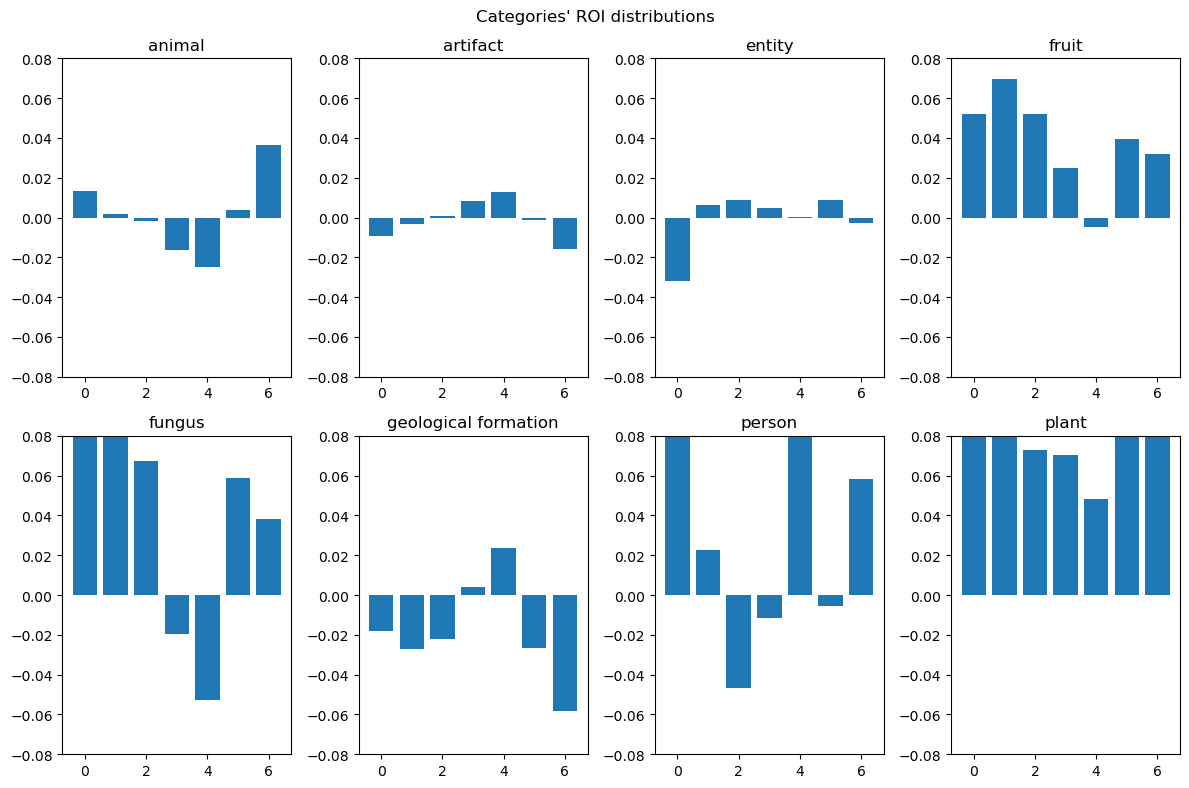

In [31]:
# Plot ROI distributions' means over all categories
# (Hardcoded to only work on category hierarchy 0 for now)

unique_labels = np.unique(labels[0, :])
# Lists to store values
total_roi_values = np.zeros((len(unique_labels), len(dat['roi_names']) - 1))
# (I didn't know how to get the sample count for each category?)
category_counts = [589, 812, 72, 77, 5, 192, 2, 1]

# Loop to go through each sample 
for i in range(len(labels[0])):
    # Loop to go through each unique label (category)
    for label in range(len(unique_labels)):
        # Assign computed ROI distribution to total ROI value list in correct index (hence the previous loop)
        if labels[0][i] == unique_labels[label]:
            total_roi_values[label] += compute_roi_bins(i)

# Loop to update total ROI value list to means
for label in range(len(total_roi_values)):
    total_roi_values[label] /= category_counts[label]

barplot_roi_distribution("Categories' ROI distributions", total_roi_values, unique_labels, ylim=[-0.08, 0.08], plot_rows=2, plot_cols=4)

## Preprocessing

### Removing categories with few samples

In [103]:
# Get indices for categories to remove (person, fungus, plant, instrumentality)
remove_indices_training = np.empty((0), dtype=int)
remove_indices_training = np.append(remove_indices_training, np.where(labels[0, :] == 'person')[0])
remove_indices_training = np.append(remove_indices_training, np.where(labels[0, :] == 'fungus')[0])
remove_indices_training = np.append(remove_indices_training,  np.where(labels[0, :] == 'plant')[0])
remove_indices_training = np.append(remove_indices_training, np.where(labels[1, :] == 'instrumentality')[0])
remove_indices_test = np.empty((0), dtype=int)
remove_indices_test = np.append(remove_indices_test, np.where(val_labels[0, :] == 'person')[0])
remove_indices_test = np.append(remove_indices_test, np.where(val_labels[0, :] == 'fungus')[0])
remove_indices_test = np.append(remove_indices_test,  np.where(val_labels[0, :] == 'plant')[0])
remove_indices_test = np.append(remove_indices_test, np.where(val_labels[1, :] == 'instrumentality')[0])

# Remove the data
# Training
training_inputs = np.delete(dat["stimuli"], remove_indices_training, axis=0)
training_outputs = np.delete(dat["responses"], remove_indices_training, axis=0)
training_labels = np.delete(labels, remove_indices_training, axis=1)
# Test
test_inputs = np.delete(dat["stimuli_test"], remove_indices_test, axis=0)
test_outputs = np.delete(dat["responses_test"], remove_indices_test, axis=0)
test_labels = np.delete(val_labels, remove_indices_test, axis=1)

print('Original training input size:', dat['stimuli'].shape)
print('Training input:', training_inputs.shape)
print('Training output:', training_outputs.shape)
print('Training labels:', training_labels.shape)
print('Original test input', dat['stimuli_test'].shape)
print('Test input:', test_inputs.shape)
print('Test output:', test_outputs.shape)
print('Test labels:', test_labels.shape)

Original training input size: (1750, 128, 128)
Training input: (1390, 128, 128)
Training output: (1390, 8428)
Training labels: (4, 1390)
Original test input (120, 128, 128)
Test input: (105, 128, 128)
Test output: (105, 8428)
Test labels: (4, 105)


### Reducing output size to number of ROI's instead of voxels

In [5]:
# Preprocess outputs to be the mean of each ROI instead of each voxel.
# This reduces the outputs to be predicted from 8428 to 7, hopefully not losing too much detail in the data in the process.
def reduce_outputs_to_ROIs(outputs):
    roi_count_dict = dict(zip(dat["roi_names"], np.bincount(dat["roi"])))
    roi_order = np.argsort(dat['roi'])
    sorted_responses = training_outputs[:, roi_order]

    training_outputs_reduced_to_ROIs = np.zeros((len(outputs), 7))
    for sample in range(len(training_outputs_reduced_to_ROIs)):
        oldValue = 0
        count = 0
        for key, value in roi_count_dict.items():
            if value > 0:
                response_values = sorted_responses[:, oldValue:oldValue+value]
                summed_roi = np.mean(response_values[sample])
                training_outputs_reduced_to_ROIs[sample][count] = summed_roi
                count += 1
            oldValue = value
    return training_outputs_reduced_to_ROIs

print(reduce_outputs_to_ROIs(training_outputs).shape)
print('Example values:', reduce_outputs_to_ROIs(training_outputs)[0])

(1390, 7)
Example values: [-0.36620308 -0.36129435 -0.29608064 -0.34640159 -0.17965585 -0.37665786
 -0.32373576]


# Encoder model

In [99]:
# Variables
batch_size = 128
num_epochs = 500

In [61]:
# CNN model for voxel-wise encoding
class EncoderModel(nn.Module):
    def __init__(self, dimension_length, num_outputs):
        super(EncoderModel, self).__init__()

        # This model takes inspiration from: https://github.com/dansuh17/alexnet-pytorch/blob/master/model.py
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4),  # (b x 96 x 30 x 30)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # section 3.3
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 14 x 14)
            nn.Conv2d(96, 256, 5, padding=2),  # (b x 256 x 14 x 14)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 6 x 6)
            nn.Conv2d(256, 384, 3, padding=1),  # (b x 384 x 6 x 6)
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, padding=1),  # (b x 384 x 6 x 6)
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1),  # (b x 256 x 6 x 6)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 2 x 2)
        )
        # classifier is just a name for linear layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=(256 * 2 * 2), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=num_outputs),
        )


    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension for grayscale images

        x = self.net(x)
        x = x.view(-1, 256 * 2 * 2)  # reduce the dimensions for linear layer input
        return self.classifier(x)

        return x

In [9]:
def get_current_time():
    # Saving model - using time as unique identifier for name
    t = time.localtime()
    current_time = time.strftime("%D_%H_%M_%S", t)

    #make the day format have a - instead of /
    current_time = current_time.replace("/","_")

    #time as string
    timeString = str(current_time)

    return timeString

In [105]:
class Encoder():
    def __init__(self, input, output):
        self.input = input
        self.output = output
        self.losses = []
        self.best_loss = 1000000
    
    # Method for setting up model and needed elements for it to be trained
    def setup_model(self, batch_size):
        # Seperate data
        x_train = self.input
        y_train = self.output

        # Create tensor from training inputs and targets
        x_train_tensor, y_train_tensor = torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float()
        training_data_tensor = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
        # Create dataloader from tensor
        train_dataloader = torch.utils.data.DataLoader(training_data_tensor, batch_size, shuffle=True)

        # Create encoder model
        encoder_model = EncoderModel(x_train_tensor.shape[1], self.output.shape[1])
        
        # MSELoss instead of CrossEntropy beause it is more of a regression problem than classification
        criterion = nn.MSELoss()

        # Optimizer
        optimizer = optim.Adam(encoder_model.parameters(), lr=0.0001)
        #optimizer = optim.SGD(encoder_model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-6, nesterov=True)

        return encoder_model, criterion, optimizer, train_dataloader

    # Method for training the model one epoch
    def train_one_epoch(self, train_dataloader, optimizer, criterion, encoder, epoch):
        train_running_loss = 0.0
        last_loss = 0.0

        # Put the model in training mode
        encoder = encoder.train()

        # Iterate through the data
        for i, data in enumerate(train_dataloader):
            inputs, targets = data

            outputs = encoder(inputs.float())
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()

            # Update model params
            optimizer.step()

            train_running_loss += loss.detach().item()
            last_loss = loss.detach().item()

            #if i % 100 == 0 and i != 0:
            #    print('Epoch: {}, Batch: {}, Loss: {}'.format(epoch, i, train_running_loss / 100))
            #    train_running_loss = 0.0
            
        return last_loss


    # Method for training the model fully
    def train(self, batch_size, num_epochs):
        timestamp = get_current_time()
        
        # Setup model
        encoder_model, criterion, optimizer, train_dataloader = self.setup_model(batch_size)
        
        # Training
        train_running_loss = 0.0
        for epoch in range(num_epochs):
            train_running_loss = self.train_one_epoch(train_dataloader, optimizer, criterion, encoder_model, epoch)
            self.losses.append(train_running_loss)

            if train_running_loss < self.best_loss:
                self.best_loss = train_running_loss
                best_model = encoder_model.state_dict()
                torch.save(best_model, os.path.join('./trained_models/', 'trainedmodel_{}.pth'.format(timestamp)))

            # Print loss value after each epoch
            print('Epoch: {} | Loss: {}'.format(epoch, train_running_loss))
        
            if (epoch+1) % 10 == 0:
                # Plot loss curve
                plt.figure(figsize=(10, 5))
                plt.title("Encoder Loss")
                plt.plot(self.losses, label="Encoder Loss")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.legend()
                # Save plot in png file if wanted
                #plt.savefig(f'loss_plotepoch{epoch+1}.png')
                plt.show()

        return encoder_model

Original input data shape: (1390, 128, 128)
Original outputs data shape: (1390, 500)
Epoch: 0 | Loss: 0.9860696196556091
Epoch: 1 | Loss: 0.9871646761894226
Epoch: 2 | Loss: 0.9713156223297119
Epoch: 3 | Loss: 0.9549960494041443
Epoch: 4 | Loss: 1.0158777236938477
Epoch: 5 | Loss: 0.9425367712974548
Epoch: 6 | Loss: 0.9498659372329712
Epoch: 7 | Loss: 0.9924336075782776
Epoch: 8 | Loss: 0.9842085242271423
Epoch: 9 | Loss: 0.9949465394020081


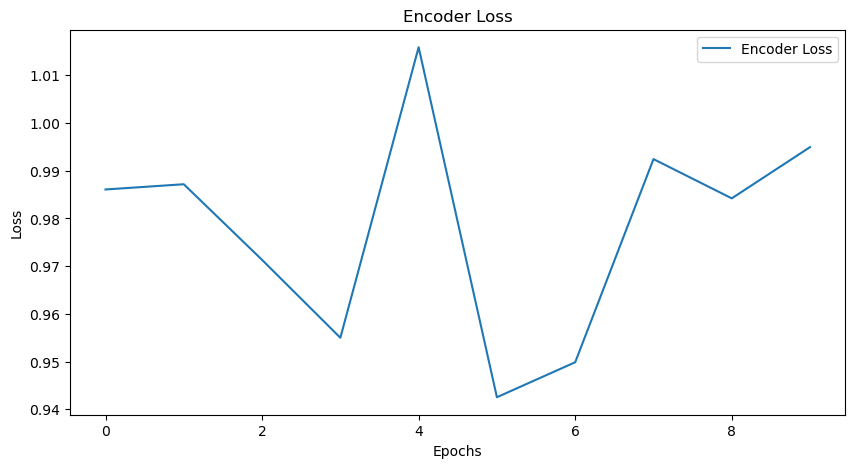

Epoch: 10 | Loss: 0.9862223267555237
Epoch: 11 | Loss: 0.9907053709030151
Epoch: 12 | Loss: 0.9874215126037598
Epoch: 13 | Loss: 1.0200241804122925
Epoch: 14 | Loss: 1.0081501007080078
Epoch: 15 | Loss: 0.9968544244766235
Epoch: 16 | Loss: 1.0192095041275024
Epoch: 17 | Loss: 0.9780921936035156
Epoch: 18 | Loss: 1.006922721862793
Epoch: 19 | Loss: 0.9677199125289917


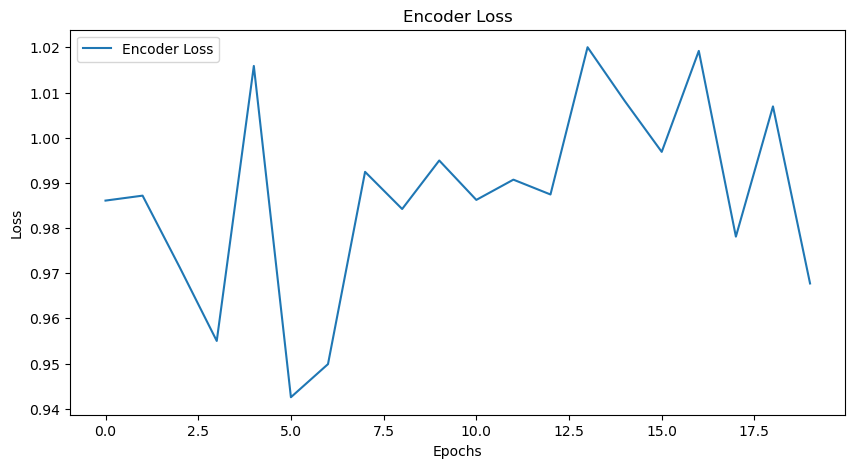

Epoch: 20 | Loss: 0.9849429726600647
Epoch: 21 | Loss: 0.9665350914001465
Epoch: 22 | Loss: 0.9775968790054321
Epoch: 23 | Loss: 0.9694375991821289
Epoch: 24 | Loss: 0.9868767261505127
Epoch: 25 | Loss: 0.9875167608261108
Epoch: 26 | Loss: 0.9683498740196228
Epoch: 27 | Loss: 0.965671181678772
Epoch: 28 | Loss: 0.9380204677581787
Epoch: 29 | Loss: 0.9889315366744995


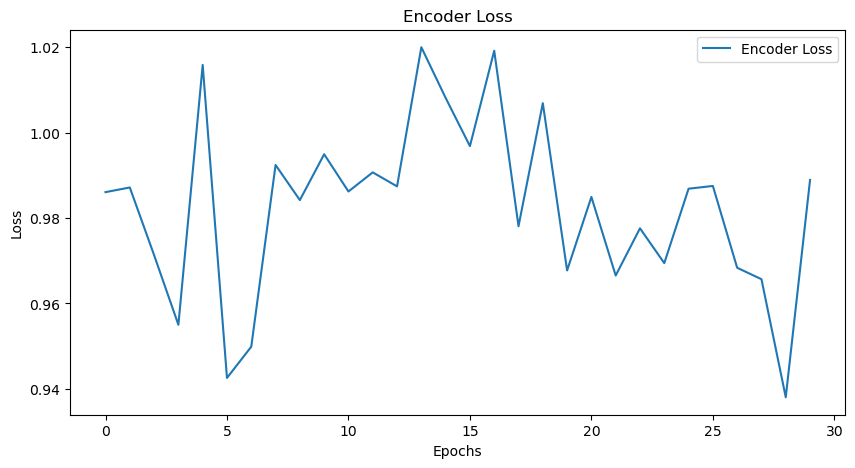

Epoch: 30 | Loss: 0.9771630764007568
Epoch: 31 | Loss: 0.9347092509269714
Epoch: 32 | Loss: 0.9897087812423706
Epoch: 33 | Loss: 0.9232425689697266
Epoch: 34 | Loss: 0.9185696244239807
Epoch: 35 | Loss: 0.9624732732772827
Epoch: 36 | Loss: 0.9434242844581604
Epoch: 37 | Loss: 0.9261226058006287
Epoch: 38 | Loss: 0.9313696026802063
Epoch: 39 | Loss: 0.9268606305122375


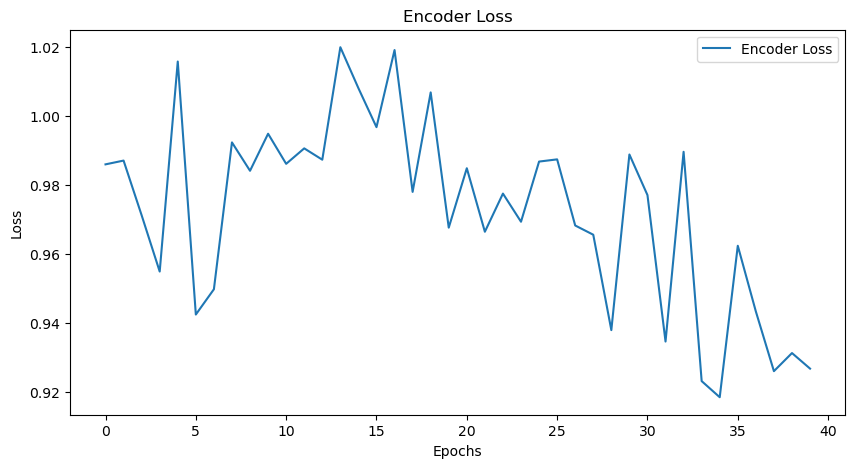

Epoch: 40 | Loss: 0.9441105127334595
Epoch: 41 | Loss: 0.8781276941299438
Epoch: 42 | Loss: 0.912462055683136
Epoch: 43 | Loss: 0.888500452041626
Epoch: 44 | Loss: 0.9058732986450195
Epoch: 45 | Loss: 0.898212194442749
Epoch: 46 | Loss: 0.8703330755233765
Epoch: 47 | Loss: 0.9056259989738464
Epoch: 48 | Loss: 0.9088549017906189
Epoch: 49 | Loss: 0.8796274065971375


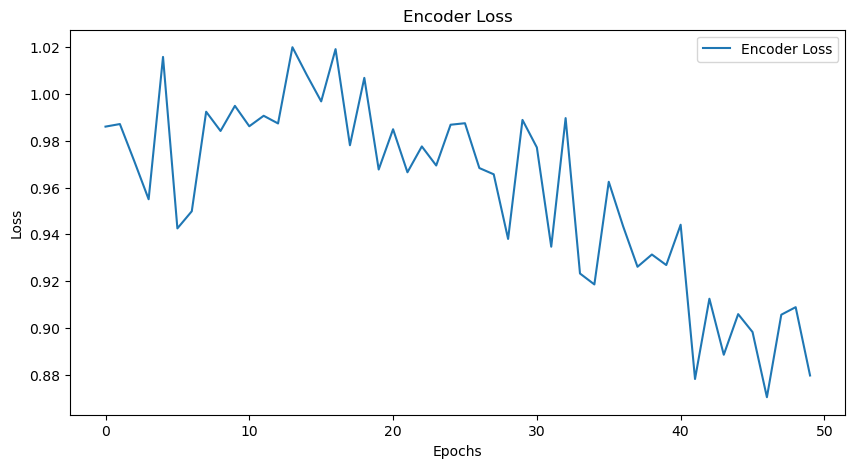

Epoch: 50 | Loss: 0.8964326977729797
Epoch: 51 | Loss: 0.879272997379303
Epoch: 52 | Loss: 0.8907318115234375
Epoch: 53 | Loss: 0.881731390953064
Epoch: 54 | Loss: 0.8853676319122314
Epoch: 55 | Loss: 0.8945488929748535
Epoch: 56 | Loss: 0.8840808272361755
Epoch: 57 | Loss: 0.8934526443481445
Epoch: 58 | Loss: 0.883650004863739
Epoch: 59 | Loss: 0.8821341395378113


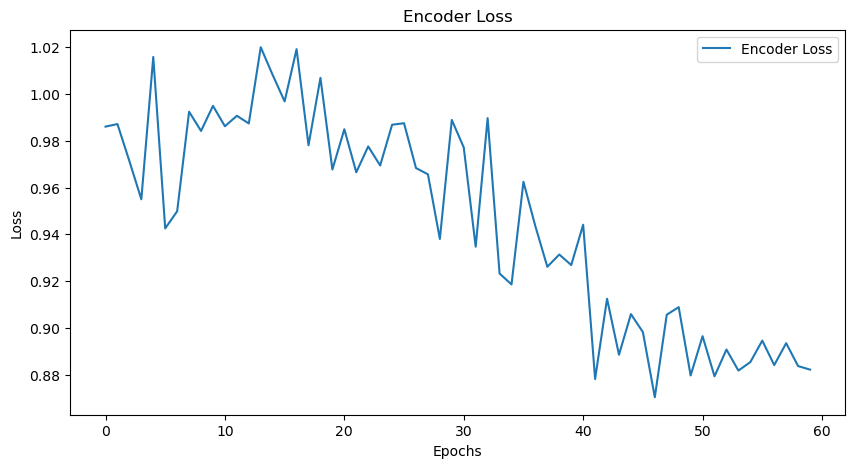

Epoch: 60 | Loss: 0.8678755760192871
Epoch: 61 | Loss: 0.8948958516120911
Epoch: 62 | Loss: 0.8824349641799927
Epoch: 63 | Loss: 0.8842839598655701
Epoch: 64 | Loss: 0.8535307049751282
Epoch: 65 | Loss: 0.8820520043373108
Epoch: 66 | Loss: 0.8953015804290771
Epoch: 67 | Loss: 0.8650062680244446
Epoch: 68 | Loss: 0.8652957677841187
Epoch: 69 | Loss: 0.8889688849449158


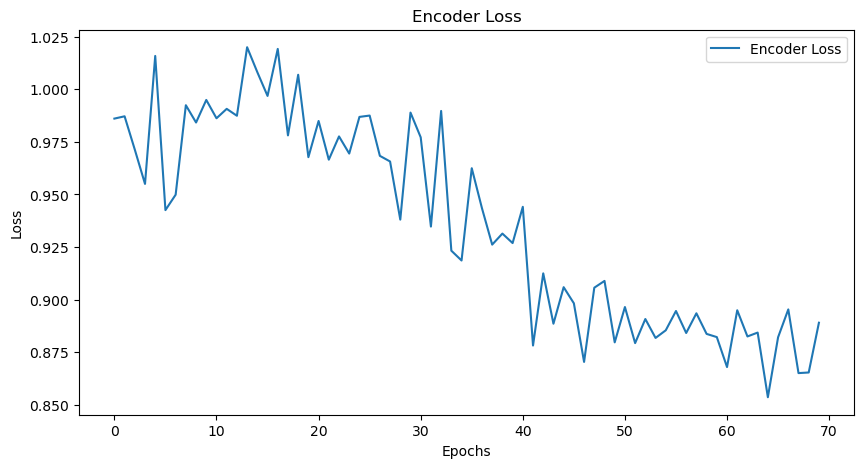

Epoch: 70 | Loss: 0.8671345710754395
Epoch: 71 | Loss: 0.8397607803344727
Epoch: 72 | Loss: 0.9046308398246765
Epoch: 73 | Loss: 0.8703870177268982
Epoch: 74 | Loss: 0.8764212131500244
Epoch: 75 | Loss: 0.8331550359725952
Epoch: 76 | Loss: 0.8483932018280029
Epoch: 77 | Loss: 0.8447700142860413
Epoch: 78 | Loss: 0.8765676617622375
Epoch: 79 | Loss: 0.8481430411338806


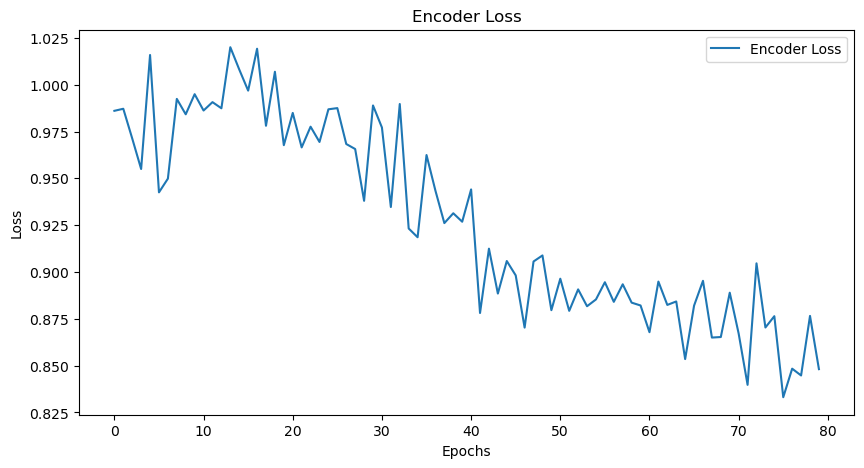

Epoch: 80 | Loss: 0.8428329825401306
Epoch: 81 | Loss: 0.8272284269332886
Epoch: 82 | Loss: 0.8355908989906311
Epoch: 83 | Loss: 0.8693894743919373
Epoch: 84 | Loss: 0.8498603701591492
Epoch: 85 | Loss: 0.8331624865531921
Epoch: 86 | Loss: 0.8432042598724365
Epoch: 87 | Loss: 0.8592112064361572
Epoch: 88 | Loss: 0.8264003992080688
Epoch: 89 | Loss: 0.8582448363304138


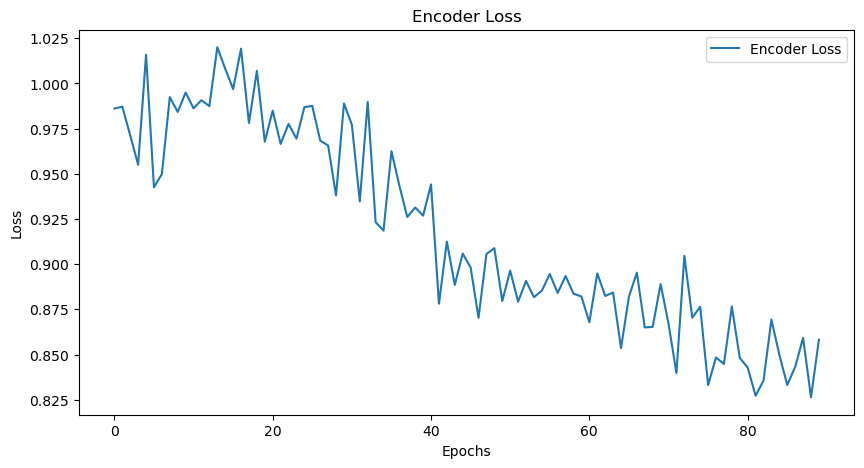

Epoch: 90 | Loss: 0.8515885472297668
Epoch: 91 | Loss: 0.837973415851593
Epoch: 92 | Loss: 0.8418632745742798
Epoch: 93 | Loss: 0.8307086825370789
Epoch: 94 | Loss: 0.8336542844772339
Epoch: 95 | Loss: 0.8210390210151672
Epoch: 96 | Loss: 0.833604097366333
Epoch: 97 | Loss: 0.8339331746101379
Epoch: 98 | Loss: 0.8350451588630676
Epoch: 99 | Loss: 0.8253673315048218


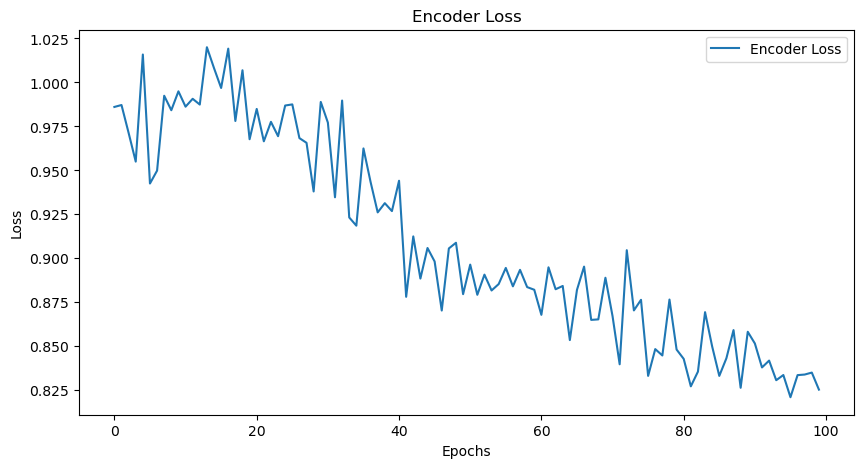

Epoch: 100 | Loss: 0.8187376260757446
Epoch: 101 | Loss: 0.8191495537757874
Epoch: 102 | Loss: 0.8437983393669128
Epoch: 103 | Loss: 0.7853737473487854
Epoch: 104 | Loss: 0.8274073600769043
Epoch: 105 | Loss: 0.8385072946548462
Epoch: 106 | Loss: 0.839309573173523
Epoch: 107 | Loss: 0.8408480882644653


KeyboardInterrupt: 

In [106]:
print('Original input data shape:', training_inputs.shape)
print('Original outputs data shape:', training_outputs.shape)

# Setup model and train it
encoder = Encoder(training_inputs, training_outputs)
trained_model = encoder.train(batch_size=batch_size, num_epochs=num_epochs)

# Testing model

In [81]:
# Try model predicting data from a dataloader
def predicted_actual_values(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_preds = []
    all_actual = []
    model.eval()
    with torch.no_grad():
        for data, targets in dataloader:
            # Ensure data is on the same device as the model
            data = data.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(data)
            all_preds.extend(outputs.cpu().numpy())
            all_actual.extend(targets.cpu().numpy())

    return np.array(all_preds), np.array(all_actual)

# Compute accuracy of model predictions based on predictions and actual values
def compute_rmse(predictions, actual):
    rmse = mean_squared_error(actual, predictions, squared=False)
    return rmse

# Plot a confusion matrix, visualising the model's predictions compared to the true labels
def plot_confusion_matrix(predictions, actual):
    cm = confusion_matrix(actual, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Try running trained model on test data
def test_trained_model(model, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    x_test = test_inputs
    y_test = test_outputs

    # Create tensor from training inputs and targets
    x_test_tensor, y_test_tensor = torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float()
    test_data_tensor = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
    # Create dataloader from tensor
    test_dataloader = torch.utils.data.DataLoader(test_data_tensor, batch_size, shuffle=True)
    
    # Plot confusion matrix and get predicted/actual results
    predicted_results, actual_results = predicted_actual_values(model, test_dataloader)
    print('Predictions:')
    print(predicted_results[0][0:10])
    print('Actual:')
    print(actual_results[0][0:10])

    rmse = compute_rmse(predicted_results, actual_results)
    print('Achieved RMSE:', "%.2f" % rmse)
    
    #plot_confusion_matrix(predicted_results, actual_results)

In [107]:
# Load model
print('Input training shape:', training_inputs.shape)
#print(reduce_outputs_to_ROIs(training_outputs).shape)
print('Input test shape:', test_inputs.shape)
#print(reduce_outputs_to_ROIs(test_outputs).shape)

model = EncoderModel(test_inputs.shape[1], test_outputs.shape[1])

model.load_state_dict(torch.load('./trained_models/trainedmodel_11_28_23_12_40_24.pth'))

# Test model
test_trained_model(model=model, batch_size=batch_size)

Input training shape: (1390, 128, 128)
Input test shape: (105, 128, 128)
Predictions:
[ 0.00146237  0.31195316 -0.14888787  0.11238037 -0.0291082   0.00972974
 -0.23268521  0.23099534  0.02608611  0.13080221]
Actual:
[ 0.12146293 -0.36214557  0.266393   -0.8244774  -0.3051253  -0.5652453
 -0.6886045   0.631157    0.30771047 -1.180108  ]
Achieved RMSE: 0.52
